In [1]:
import pandas as pd
import numpy as np
import sys, os
import matplotlib.pyplot as plt
import warnings

sys.path.append(os.getcwd() + "/../src/")

from utils import create_dataset

btc = create_dataset()
btc = btc.reset_index(drop=True)

SEED = 2052
np.random.seed(2052)

In [2]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.svm import SVR

from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.preprocessing import SplineTransformer, PowerTransformer
from sklearn.metrics import mean_absolute_percentage_error, r2_score

from sklearn.pipeline import Pipeline

ensemble = VotingRegressor(
    estimators=[
        ('svm', SVR()),
        ('rf', RandomForestRegressor(random_state=SEED)),
        ('ada', AdaBoostRegressor(random_state=SEED)),
        ('xgb', XGBRegressor(random_state=SEED))
    ]
)

pipeline = Pipeline(
    [
        ('power-transformer', PowerTransformer()),
        ('spline', SplineTransformer(n_knots=10, degree=4)),
        ('ensemble', ensemble)
    ]
)

In [3]:
btc.iloc[-1].Date

Timestamp('2024-07-08 20:00:00+0000', tz='UTC')

In [4]:
X_pred = btc.iloc[-1].drop(['Date', 'target'])
btc = btc.dropna()
X, y = btc.drop(columns=['target', 'Date']).astype(np.float64), btc['target'].astype(np.float64)

In [10]:
btc

,Date,Open,ema_12,ema_26,macd,kst,bollinger_high,bollinger_low,ulcer_index,kama,ppo,roc,rsi,stochrsi,target
26,2016-04-11 20:00:00+00:00,422.29,411.625128,384.634186,26.990943,-377.910751,460.001698,365.541302,9.744723,432.369121,7.017302,9.925552,60.698268,0.247168,1.238485
27,2016-04-18 20:00:00+00:00,427.52,414.070493,387.810913,26.259581,-349.302840,459.937756,370.657244,9.769754,431.826905,6.771233,9.63738,61.777753,0.589043,8.142309
28,2016-04-25 20:00:00+00:00,462.33,421.495033,393.330845,28.164188,-315.790522,466.813820,370.245180,9.013039,435.630086,7.160432,24.292282,68.064984,1.000000,-4.00796
29,2016-05-02 20:00:00+00:00,443.8,424.926566,397.069301,27.857265,-286.079804,466.566942,370.336058,8.405597,435.697826,7.015719,18.958909,62.199718,0.533573,4.098693
30,2016-05-09 20:00:00+00:00,461.99,430.628633,401.878242,28.750391,-259.843665,470.683957,368.557043,7.100576,436.632890,7.154005,15.315877,65.355721,0.780993,-2.043334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,2024-06-03 20:00:00+00:00,69182.046875,65259.584391,58113.024141,7146.560250,859.483347,81988.315043,40818.294332,7.349231,63957.100991,12.297691,-3.917275,65.526621,0.193234,0.427981
451,2024-06-10 20:00:00+00:00,69478.132812,65908.591840,58954.884042,6953.707798,840.015365,81177.653172,44598.044874,7.408726,63984.037777,11.794965,3.648718,65.798963,0.204373,-4.094589
452,2024-06-17 20:00:00+00:00,66633.289062,66020.083720,59523.654785,6496.428936,794.096468,79964.049310,48174.914753,7.648734,64070.475618,10.914029,-6.141849,60.826736,0.001425,-10.623631
453,2024-06-24 20:00:00+00:00,59554.414062,65025.365312,59525.933250,5499.432062,743.974072,77668.450521,52153.599869,8.700358,63961.611911,9.238716,-14.562561,50.583615,0.000000,6.139789


In [5]:
ts_cv = TimeSeriesSplit(
    n_splits=100,
    test_size=1
)

res = cross_validate(
    estimator=pipeline,
    X=X,
    y=y,
    cv=ts_cv,
    scoring=('neg_mean_absolute_percentage_error',)
)

In [6]:
print('---- Mean ----')
print(np.mean(res['test_neg_mean_absolute_percentage_error']))
print('---- Variance ----')
print(np.std(res['test_neg_mean_absolute_percentage_error']))

---- Mean ----
-2.87804909375947
---- Variance ----
8.237769995883284


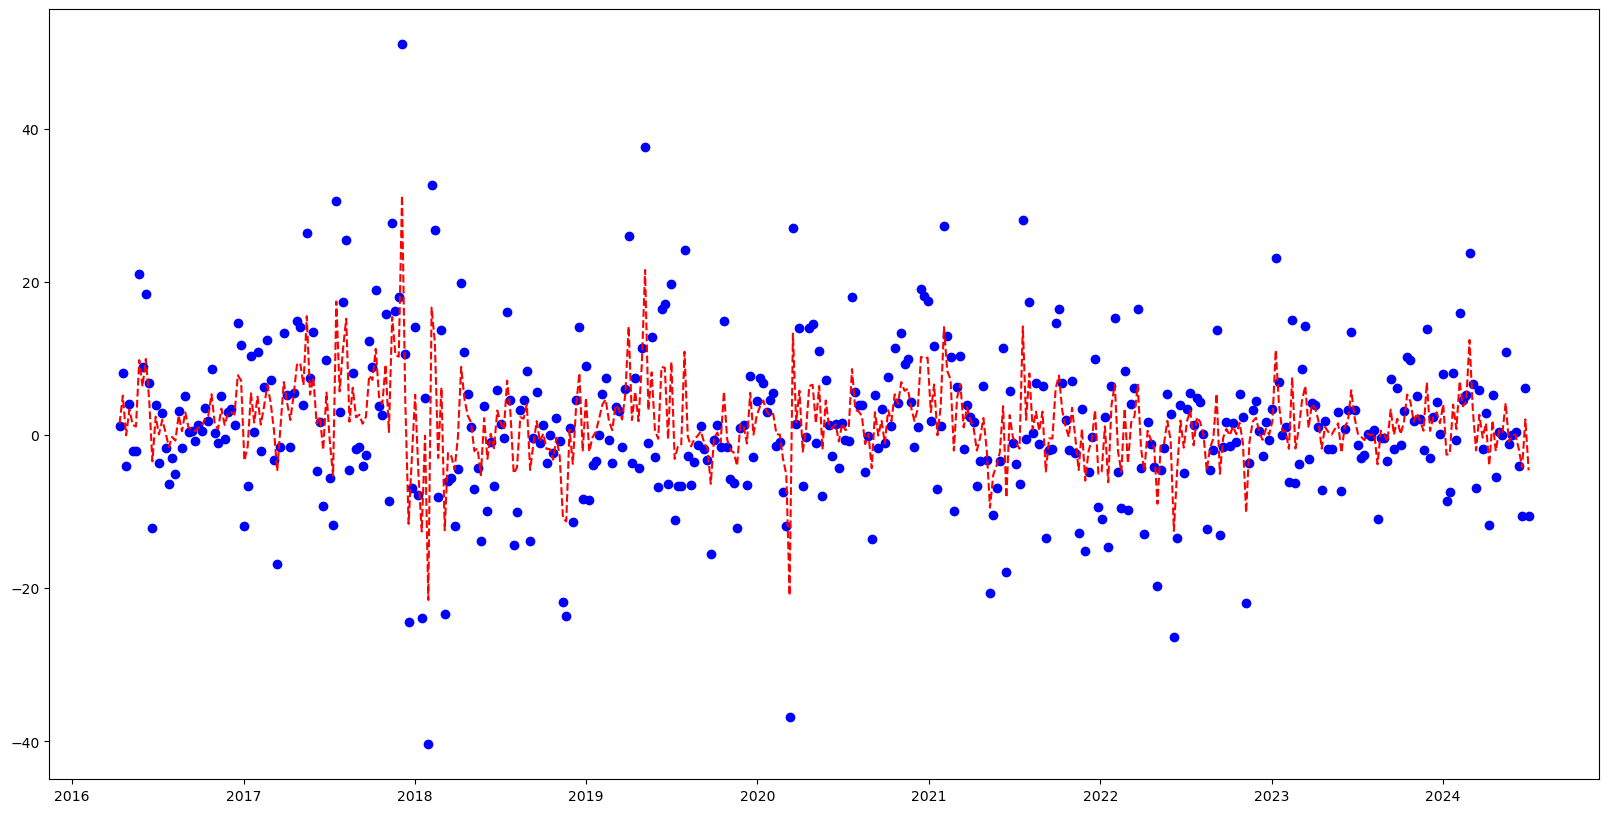

In [7]:
with warnings.catch_warnings():
    warnings.filterwarnings(action='ignore')
    pipeline.fit(X=X, y=y)
    y_pred = pipeline.predict(X)

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.scatter(btc['Date'], btc['target'], c='b')
ax.plot(btc['Date'], y_pred, c='r', linestyle='--')
fig.show()

In [8]:
print("----- MAPE -----")
print(f"{mean_absolute_percentage_error(btc['target'], y_pred)}")
print("----- R2 ------")
print(f"{r2_score(btc['target'], y_pred)}")

----- MAPE -----
1.0618557030284999
----- R2 ------
0.7167019408593729


In [9]:
print("---- Next Prediction ----")
print(pipeline.predict(X_pred.values.reshape(1, -1)))

---- Next Prediction ----
[-0.47862037]
